# Ultimate Take-Home Challenge

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

## Part 1: Eploratory data analysis

## Imports

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Prepare the data

Open the file and store data in a dictionary

In [235]:
with open("logins.json", "r") as json_data:
    dict_data = json.load(json_data)

Investigate file

In [236]:
dict_data.keys()

dict_keys(['login_time'])

In [237]:
len(dict_data['login_time'])

93142

Create a Pandas DataFrame to aggregate these login counts based on 15 minute time intervals

In [238]:
timestamp = pd.to_datetime(dict_data['login_time']).sort_values()
df = pd.DataFrame(index = timestamp)
df['count'] = 1
df = df.resample('15 min').count()
df

,count
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2
1970-04-13 18:30:00,7


What does the data look like?

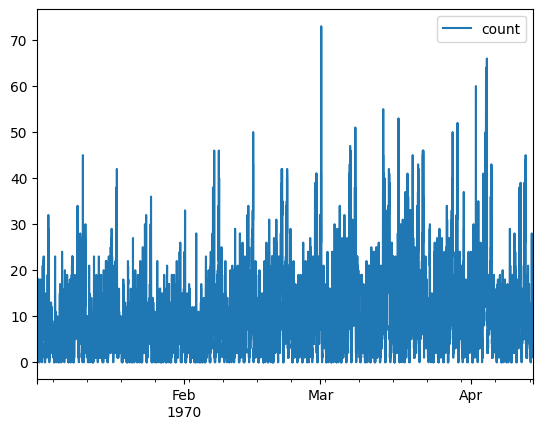

In [239]:
df.plot();

add some more features to understand the data. Here I will use the timestamp to add the month, the name of the month, the day of the year, the day of the week, the hour, the week of the year, and rolling means, maximums, minimums, and standard deviations over 1 hour, 12 hours, 1 day, and 3 days. 

In [240]:
df['month'] = df.index.month
df['month_name'] = df.index.month_name()
df['dayofyear'] = df.index.dayofyear
df['day'] = df.index.dayofweek
df['hr'] = df.index.hour
df['week_of_year'] = df.index.isocalendar().week
df['rolling_mean_1hr'] = df['count'].rolling(window=4).mean()
df['rolling_mean_12hrs'] = df['count'].rolling(window=48).mean()
df['rolling_mean_1day'] = df['count'].rolling(window=96).mean()
df['rolling_mean_3days'] = df['count'].rolling(window=288).mean()
df['rolling_max_12hrs'] = df['count'].rolling(window=48).max()
df['rolling_max_1day'] = df['count'].rolling(window=96).max()
df['rolling_max_3days'] = df['count'].rolling(window=288).max()
df['rolling_min_12hrs'] = df['count'].rolling(window=48).min()
df['rolling_min_1day'] = df['count'].rolling(window=96).min()
df['rolling_min_3days'] = df['count'].rolling(window=288).min()
df['rolling_std_12hrs'] = df['count'].rolling(window=48).min()
df['rolling_std_1day'] = df['count'].rolling(window=96).std()
df['rolling_std_3days'] = df['count'].rolling(window=288).std()

## Analysis and finding meaning in the trends

Below, I will plot the rolling mean, maximum, minimum, and standard deviation over 3 days to investigate trends in logins.

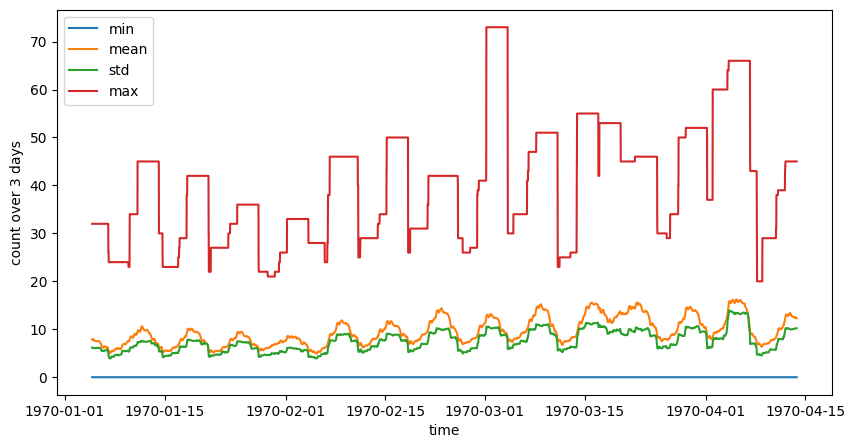

In [241]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(df['rolling_min_3days'])
ax.plot(df['rolling_mean_3days'])
ax.plot(df['rolling_std_3days'])
ax.plot(df['rolling_max_3days'])
ax.legend (['min','mean','std','max'])
ax.set_ylabel('count over 3 days')
ax.set_xlabel('time')
plt.show()

When do the peaks occur? To find this out, I will look at trends in the rolling mean over 3 days across weeks 2, 3, 4, 5, and 6 of the year

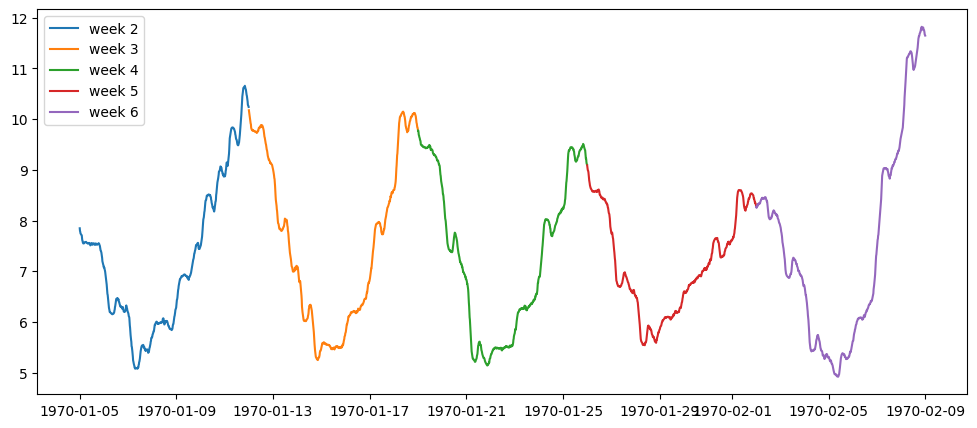

In [242]:
fig, ax = plt.subplots(1,1, figsize = (12,5))
for i in range(2,7):
    ax.plot(df[df['week_of_year'].isin([i])].index, df[df['week_of_year'].isin([i])]['rolling_mean_3days'])
plt.legend(['week 2', 'week 3', 'week 4', 'week 5', 'week 6'])
plt.show()

It looks like higher number of logins occur at the end of the week. It appears to be Sunday night.

Next, I will use a threshold of less than 6 counts (rolling average) to detect the throughs. for weeks 2, 3, 4, 5, and 6, on which days do we have a rolling average count of logins that is less than 6?

In [164]:
for i in range(2,7):
    print(df[(df['week_of_year'].isin([2])) & (df['rolling_mean_3days'] < 6)]['day'].unique())

[2 3]
[2 3]
[2 3]
[2 3]
[2 3]


It looks like we have less logins on Wednesday and Thursdays. 

Now, I am interested on the trends during the day. To do this, I will plot the rolling average count of logins over 1 hour colored by day of the week, and plot this for the first few weeks of the year.

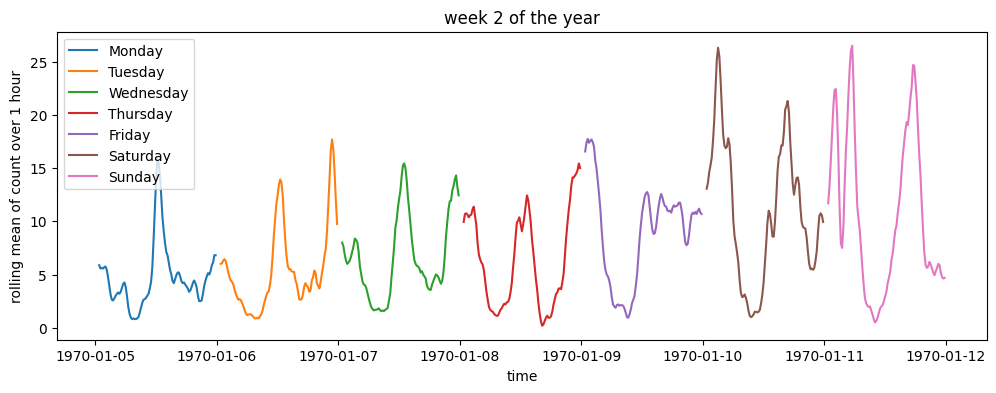

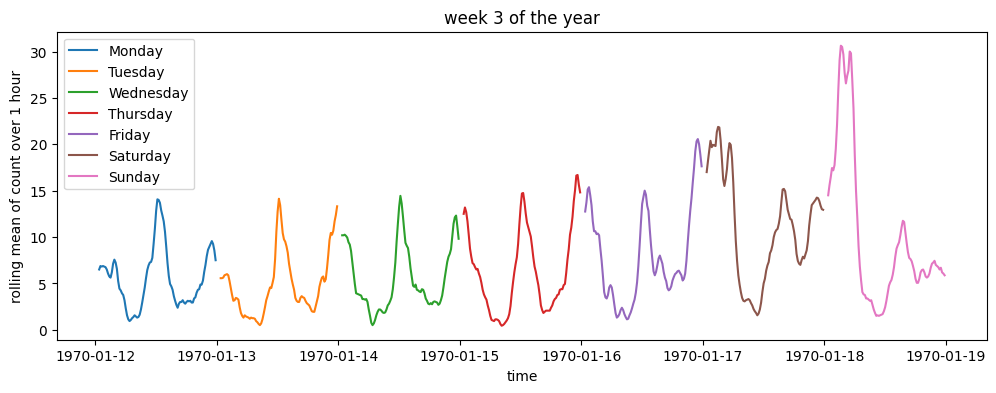

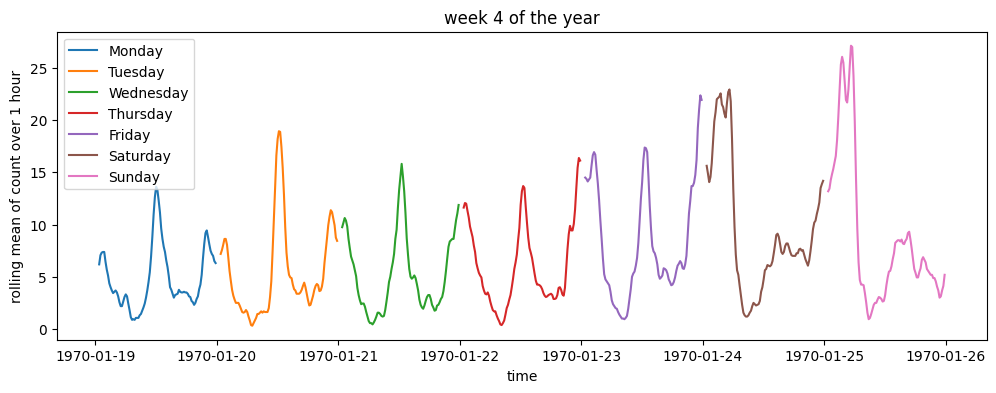

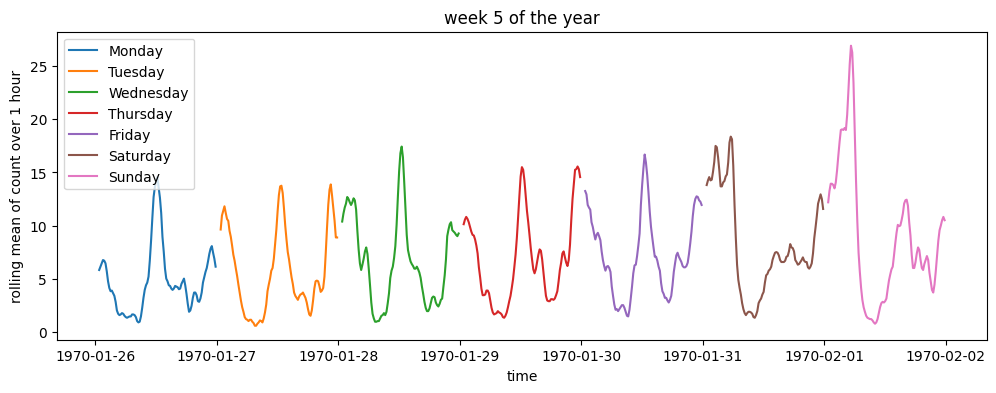

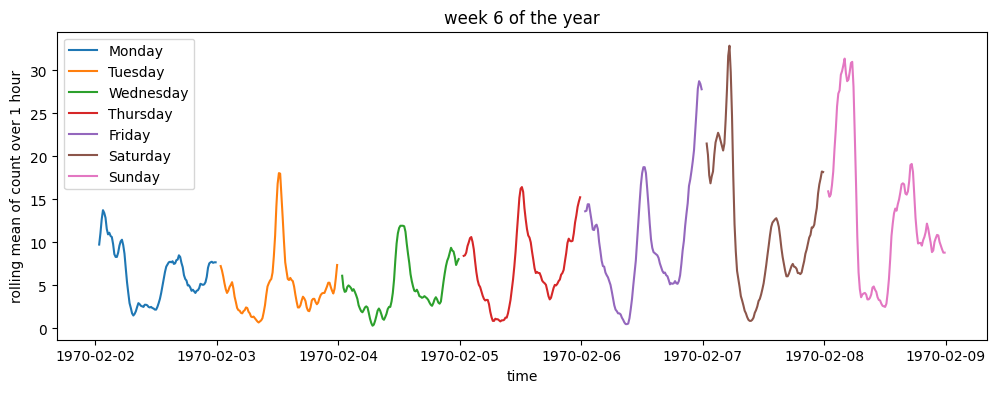

In [211]:
for i in range(2,7):
    fig, ax = plt.subplots(1,1, figsize = (12,4))
    for j in range(0,7):
        df_sample = df[(df['week_of_year'].isin([i])) & (df['day'] == j)]
        ax.plot(df[(df['week_of_year'].isin([i])) & (df['day'] == j)].index,
            df[(df['week_of_year'].isin([i])) & (df['day'] == j)]['rolling_mean_1hr'].rolling(window=4).mean())
    plt.legend(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.ylabel('rolling average count over 1 hour')
    plt.title('week {} of the year'.format(str(i)))
    plt.xlabel('time')
    plt.show()

We find a consistent trend where there seem to be peaks during the middle of the day and at night.  

To make this clearer, in the next cell we have the rolling average count over 1 hour for Monday, January 6th, and Saturday January 10th. In the first plot (on Monday), we have a higher count occurring during the day between the hours 10 AM and 3 PM, as well as night, at around 10 PM. In the second plot (on Saturday), we find the peaks just after midnight of the day prior and in the afternoon, likely due to people sleeping in on the weekends. 

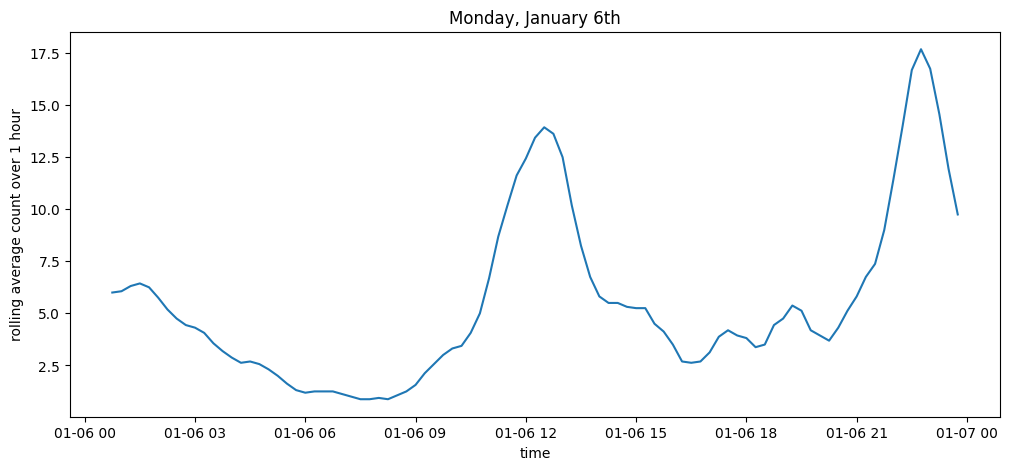

In [243]:
fig, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(df[(df['week_of_year'].isin([2])) & (df['day'] == 1)].index,
        df[(df['week_of_year'].isin([2])) & (df['day'] == 1)]['rolling_mean_1hr'].rolling(window=4).mean())
ax.set_title('Monday, January 6th')
ax.set_xlabel('time')
ax.set_ylabel('rolling average count over 1 hour')
plt.show()

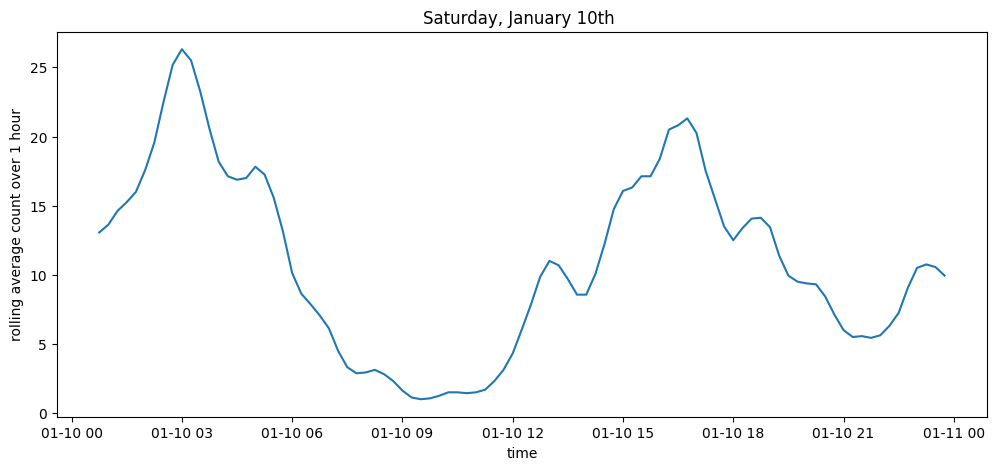

In [253]:
fig, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(df[(df['week_of_year'].isin([2])) & (df['day'] == 5)].index,
        df[(df['week_of_year'].isin([2])) & (df['day'] == 5)]['rolling_mean_1hr'].rolling(window=4).mean())
ax.set_title('Saturday, January 10th ')
ax.set_xlabel('time')
ax.set_ylabel('rolling average count over 1 hour')
plt.show()

Is there a difference in the logins for each day of the week?

The number of logins tends to be higher on Saturday and Sunday as observed below for the data overall and for each month.

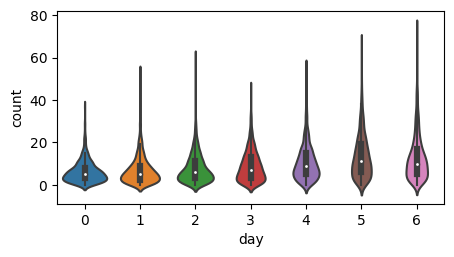

In [251]:
fig, ax = plt.subplots(1,1, figsize = (5,2.5))
sns.violinplot(data=df, x="day", y="count");

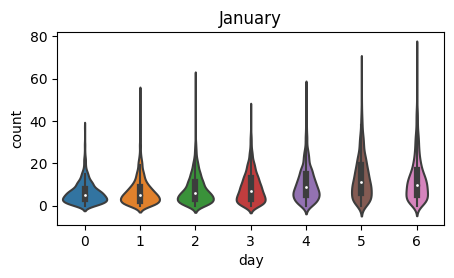

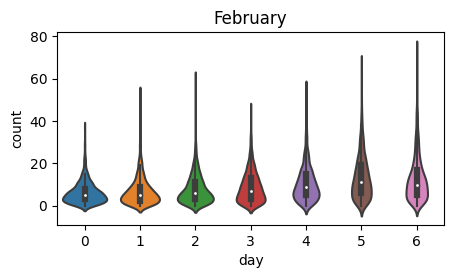

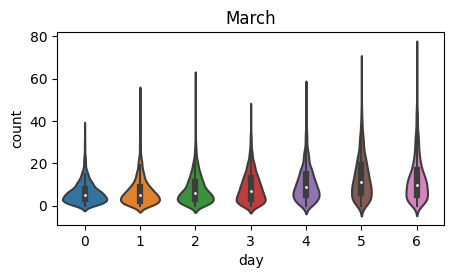

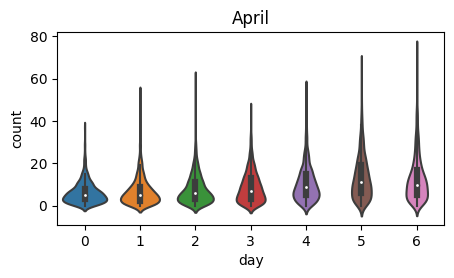

In [248]:
months = (df['month_name'].unique())
for month in months:
    fig, ax = plt.subplots(1,1, figsize = (5,2.5))
    ax.set_title(month)
    sns.violinplot(data=df, x="day", y="count");

March and April tend to have more logins compared to January and February

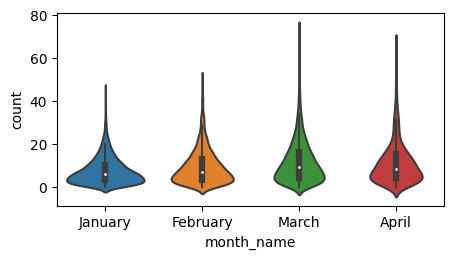

In [249]:
fig, ax = plt.subplots(1,1, figsize = (5,2.5))
sns.violinplot(data=df, x="month_name", y="count");

The afternoon and nighttime tend to have more logins compared to the morning and evening.

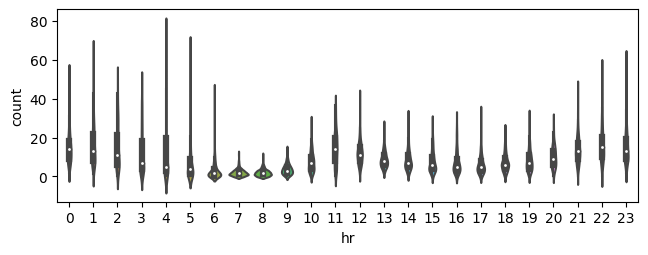

In [250]:
fig, ax = plt.subplots(1,1, figsize = (7.5,2.5))
sns.violinplot(data=df, x="hr", y="count");